In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score

In [4]:
pip install catboost

## Лабораторная работа №6: Градиентный бустинг

[Лекция](../lectures/lecture_6/lecture_6.ipynb)

1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать категориальные и количественные признаки.
2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо сформировать два набора обучающей и тестовой выборок: с закодированными категориальными признаками и с категориальными признаками без обработки.
3. Для каждого из классификаторов ($AdaBoost$, $GradientBoostingClassifier$, $XGBoost$, $CatBoost$):
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.
     > Как минимум основных: `n_estimators`/`iterations`, `learning_rate`, `depth`, параметры регуляризации $L^1$, $L^2$. Для ускорения вычислений можно сразу с заданным значением `early_stopping_rounds` &ndash; тогда понадобится еще выделить валидационный датасет ($XGBoost$) или задать значение `train_size` у $CatBoost$ (часть обучающей выборки пойдет в валидационный набор).
   - Обучить модели $XGBoost$ и $CatBoost$ с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".
   - Итого получить 6 обученных моделей.
   - Вывести метрики на тестовом наборе (как минимум `classification_report`, другие по желанию).
   - Сравнить модели, выбрать лучшую.
     > Ожидаемый результат &ndash; $XGBoost$/$CatBoost$.
4. Важность признаков:
   - С использованием `shap.TreeExplainer` получить $SHAP$-значения для лучшей модели.
   - Построить график `shap.plots.force` для одного объекта выборки и для среза произвольного размера.
   - Построить график `shap.plots.bar` для одного объекта выборки.
   - Построить график `shap.plots.waterfall` для одного объекта выборки.
   - Построить 2 графика `shap.plots.scatter` для какого-нибудь признака. На одном раскрасить относительно себя, на втором &ndash; относительно другого признака.
   - Построить график `shap.plots.beeswarm` для всех признаков.
   - Построить график `shap.plots.bar` для всех признаков.
   - На основании двух последних графиков и/или используя `feature_importance` отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.
   - Сравнить метрики до и после фильтрации.
   - Визуализировать полученное дерево решений.
5. Регрессия:
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели линейной регрессии с использованием $XGBoost$ или $CatBoost$.
     > [xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) в $XGBoost$, [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) в $CatBoost$. В целом, можно выбрать новый таргет из уже полученного разбиения на обучающую и тестовыую выборки из пункта 2.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Переобучить модель на отфильтрованном наборе признаков из пункта 4.
   - Сравнить метрики до и после фильтрации.

https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
### Описание датасета
The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The data includes features such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

1. gender - Gender refers to the biological sex of the individual, which can have an impact on their susceptibility to diabetes.
2. age - Age is an important factor as diabetes is more commonly diagnosed in older adults.
3. hypertension - Hypertension is a medical condition in which the blood pressure in the arteries is persistently elevated.
4. heart_disease - Heart disease is another medical condition that is associated with an increased risk of developing diabetes.
5. smoking_history
6. bmi - BMI (Body Mass Index) is a measure of body fat based on weight and height.
7. HbA1c_level - HbA1c (Hemoglobin A1c) level is a measure of a person's average blood sugar level over the past 2-3 months.
8. blood_glucose_level - Blood glucose level refers to the amount of glucose in the bloodstream at a given time.
9. diabets - target

Загрузим данные

In [5]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
df.shape

(100000, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [8]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [9]:
df.value_counts("diabetes")

,count
diabetes,
0,91500
1,8500


Существует дисбаланс классов

In [10]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [11]:
df.duplicated().sum()

np.int64(3854)

Избавимся от дубликатов

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


Закодируем категориальные признаки

In [15]:
le = LabelEncoder()

df['gender_encode'] = le.fit_transform(df['gender'])
df = pd.concat([df, pd.get_dummies(data = df["smoking_history"], prefix = "smoking")], axis=1)

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_encode,smoking_No Info,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
0,Female,80.0,0,1,never,25.19,6.6,140,0,0,False,False,False,False,True,False
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0,True,False,False,False,False,False
2,Male,28.0,0,0,never,27.32,5.7,158,0,1,False,False,False,False,True,False
3,Female,36.0,0,0,current,23.45,5.0,155,0,0,False,True,False,False,False,False
4,Male,76.0,1,1,current,20.14,4.8,155,0,1,False,True,False,False,False,False


In [16]:
df.columns = df.columns.str.strip().str.lower()
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,hba1c_level,blood_glucose_level,diabetes,gender_encode,smoking_no info,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
0,Female,80.0,0,1,never,25.19,6.6,140,0,0,False,False,False,False,True,False
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0,True,False,False,False,False,False
2,Male,28.0,0,0,never,27.32,5.7,158,0,1,False,False,False,False,True,False
3,Female,36.0,0,0,current,23.45,5.0,155,0,0,False,True,False,False,False,False
4,Male,76.0,1,1,current,20.14,4.8,155,0,1,False,True,False,False,False,False


Подготовим данные для обучения

In [17]:
X_encoded = df.drop(["diabetes", "gender", "smoking_history"], axis=1)
X_raw = df.drop(["diabetes", "gender_encode", 'smoking_no info', 'smoking_current', 'smoking_ever','smoking_former', 'smoking_never', 'smoking_not current'], axis=1)
y = df["diabetes"]

In [18]:
scaler = StandardScaler()
X_encoded_scaled = scaler.fit_transform(X_encoded)

X_raw_scaled = pd.DataFrame(scaler.fit_transform(X_raw.select_dtypes(include=['int64', 'float64'])), columns=X_raw.select_dtypes(include=['int64', 'float64']).columns)

X_raw_scaled_ = pd.concat([X_raw_scaled.reset_index(drop=True), X_raw[["gender", "smoking_history"]].reset_index(drop=True)], axis=1)

X_encoded_train, X_encoded_test, y_train_encoded, y_test_encoded = train_test_split(X_encoded_scaled, y, test_size=0.2, random_state=0)
X_raw_train, X_raw_test, y_train_raw, y_test_raw = train_test_split(X_raw_scaled_, y, test_size=0.2, random_state=0)

In [19]:
models_params = {
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=0, algorithm="SAMME"),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 1]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=0),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='mlogloss', random_state=0),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
            "reg_alpha": [0, 0.1],
            "reg_lambda": [1, 10]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=0, train_dir="temp_catboost_dir"),
        "params": {
            "iterations": [50, 100],
            "learning_rate": [0.01, 0.1],
            "depth": [3, 5],
            "l2_leaf_reg": [1, 3]
        }
    }
}

best_models = {}

Произведем поиск гиперпараметров

In [20]:
grid_results = {}
for name, info in models_params.items():
    print(f"\nЗапуск GridSearchCV для {name}")
    model = info["model"]
    params = info["params"]

    grid = GridSearchCV(
            estimator=model,
            param_grid=params,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
        )
    grid.fit(X_encoded_train, y_train_encoded)
    grid_results[name] = grid
    print(f"Лучшие параметры для {name}: {grid.best_params_}")
    best_models[name] = grid.best_estimator_


Запуск GridSearchCV для AdaBoost


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Лучшие параметры для AdaBoost: {'learning_rate': 1, 'n_estimators': 100}

Запуск GridSearchCV для GradientBoosting
Лучшие параметры для GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Запуск GridSearchCV для XGBoost
Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}

Запуск GridSearchCV для CatBoost
Лучшие параметры для CatBoost: {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


Обучим XGBoost и CatBoost на обучающей выборке с категориальными признаками "как есть"

In [21]:
X_raw_train[['gender', 'smoking_history']] = X_raw_train[['gender', 'smoking_history']].astype('category')
X_raw_test[['gender', 'smoking_history']] = X_raw_test[['gender', 'smoking_history']].astype('category')

In [22]:
xgb_raw = XGBClassifier(
    **grid_results['XGBoost'].best_params_,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=len(y.unique()),
    enable_categorical=True,
    random_state=0
)
cat_raw = CatBoostClassifier(
    **grid_results['CatBoost'].best_params_, verbose=0, random_state=0
)

xgb_raw.fit(X_raw_train, y_train_raw)
cat_raw.fit(X_raw_train, y_train_raw, cat_features=["gender", "smoking_history"])

best_models["XGBoost_raw"] = xgb_raw
best_models["CatBoost_raw"] = cat_raw

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:23:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Оценим полученные модели

In [23]:
for name, model in best_models.items():
    print(f"\n{name}:")
    preds = None
    if "raw" in name:
      preds = model.predict(X_raw_test)
      print(classification_report(y_test_raw, preds))
    else:
      preds = model.predict(X_encoded_test)
      print(classification_report(y_test_encoded, preds))


AdaBoost:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17562
           1       1.00      0.68      0.81      1668

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230


GradientBoosting:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17562
           1       0.98      0.69      0.81      1668

    accuracy                           0.97     19230
   macro avg       0.98      0.85      0.90     19230
weighted avg       0.97      0.97      0.97     19230


XGBoost:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17562
           1       0.99      0.69      0.81      1668

    accuracy                           0.97     19230
   macro avg       0.98      0.85      0.90     19230
weighted avg       0.97      0.97 

Все модели справились примерно одинаково. Разница заключается в 0,01 в некоторых метриках.

Перейдем к оценке важности признаков с помощью библиотеки shap

In [ ]:
shap.initjs()

In [ ]:
X_raw_scaled_.head()

,age,hypertension,heart_disease,bmi,hba1c_level,blood_glucose_level,gender,smoking_history
0,1.700840,-0.290050,4.848534,-0.314947,0.994563,0.043554,Female,never
1,0.543372,-0.290050,-0.206248,-0.000216,0.994563,-1.423096,Female,No Info
2,-0.614096,-0.290050,-0.206248,-0.000216,0.155970,0.483549,Male,never
3,-0.257952,-0.290050,-0.206248,-0.572051,-0.496269,0.410216,Female,current
4,1.522768,3.447677,4.848534,-1.061141,-0.682623,0.410216,Male,current


In [ ]:
best_model = best_models["CatBoost"]

X_data = X_raw_test.select_dtypes(include=['int64', 'float64'])

explainer = shap.TreeExplainer(best_model, data=X_data)

shap_values = explainer(X_data)

sample_idx = 0
class_idx = 0

100%|===================| 19195/19230 [01:24<00:00]       

[-4.69137925 -4.69137925 -4.69137925 ... -4.69137925 -4.69137925
 -4.69137925] (19230,) (19230, 6)


In [ ]:
shap.initjs()
shap.plots.force(
    shap.Explanation(
        base_values=explainer.expected_value,
        values=shap_values.values[0, :],
        data=X_data.iloc[0, :],

    )
)

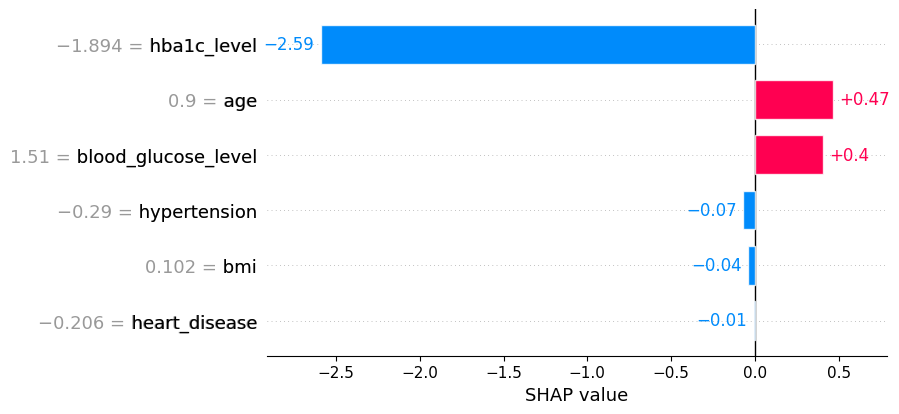

In [ ]:
shap.initjs()
shap.plots.bar(
    shap.Explanation(
        base_values=explainer.expected_value,
        values=shap_values.values[0, :],
        data=X_data.iloc[0, :],
    )
)

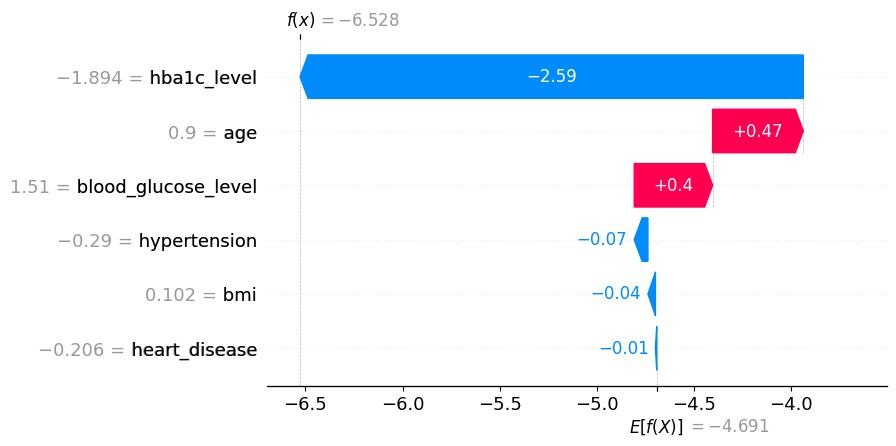

In [ ]:
shap.plots.waterfall(
    shap.Explanation(
        base_values=explainer.expected_value,
        values=shap_values.values[0, :],
        data=X_data.iloc[0, :],
    )
)

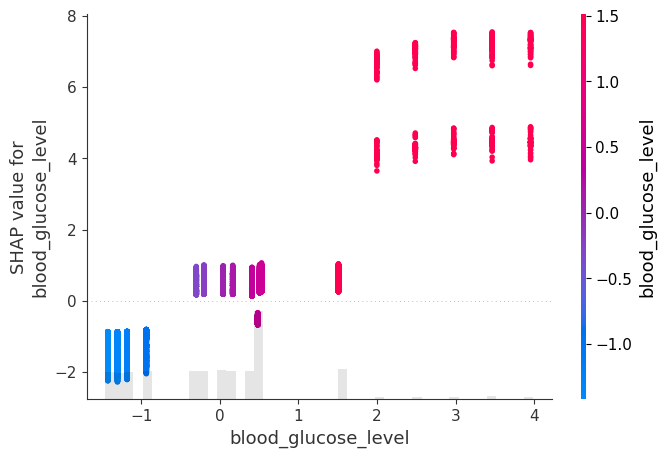

In [ ]:
shap.initjs()
shap.plots.scatter(
    shap_values[:, 5],
    color=shap_values[:, 5]
)

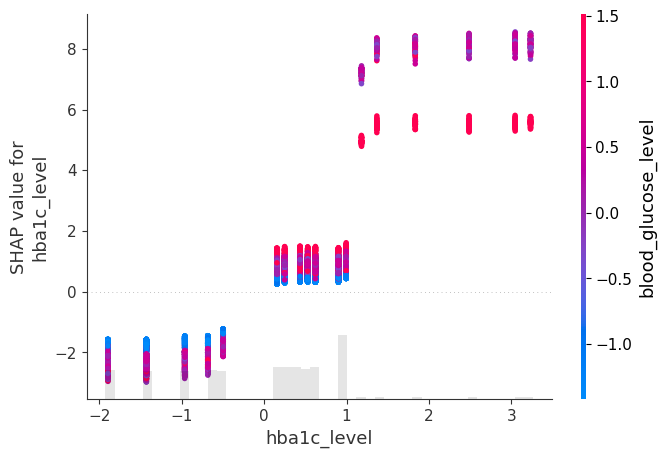

In [ ]:
shap.plots.scatter(
      shap_values[:, 4],
    color=shap_values[:, 5]
)

<Axes: xlabel='SHAP value (impact on model output)'>

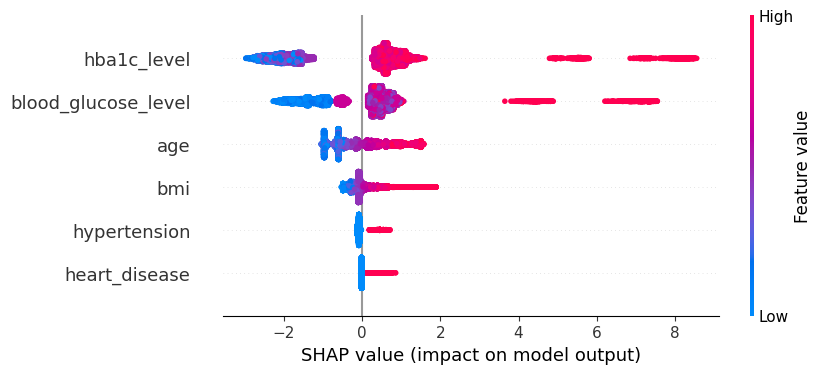

In [ ]:
shap.plots.beeswarm(
       shap_values , max_display=X_raw_train.shape[1], show=False
)

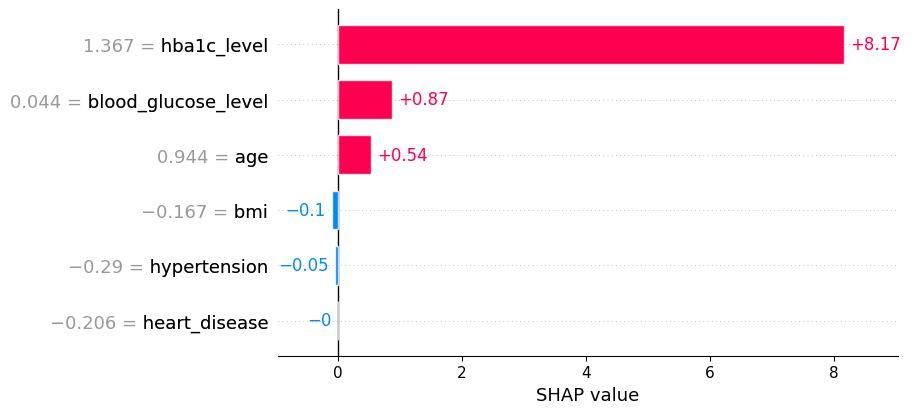

In [ ]:
shap.plots.bar(shap_values[3], max_display=X_raw_train.shape[1])

На основании двух последних графиков отфильруем признаки и переобучим лучшую модель.

In [ ]:
X_train_filtered = X_raw_train.drop(["bmi", "hypertension", "heart_disease"], axis=1)
X_test_filtered = X_raw_test.drop(["bmi", "hypertension", "heart_disease"], axis=1)

In [ ]:
cat_filtered = CatBoostClassifier(**best_model.get_params())
cat_filtered.set_params(verbose=0)

cat_filtered.fit(X_train_filtered, y_train_raw, cat_features=["gender", "smoking_history"])

In [ ]:
preds_filtered = cat_filtered.predict(X_test_filtered)
print("Классификация после отбора признаков:")
print(classification_report(y_test_raw, preds_filtered))

Классификация после отбора признаков:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17562
           1       1.00      0.68      0.81      1668

    accuracy                           0.97     19230
   macro avg       0.99      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



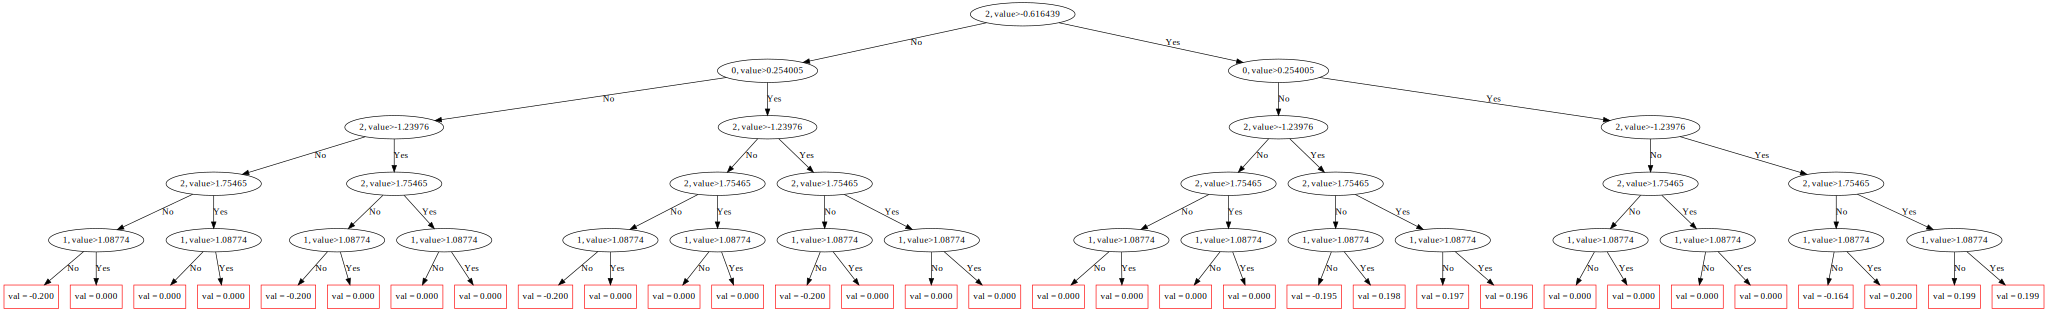

In [ ]:
cat_filtered.plot_tree(tree_idx=0)

Результаты не поменялись, но удалось уменьшить размерность пространства признаков

Перейдем к регрессии

In [ ]:
target_regression = 'bmi'

X_reg = df.drop(columns=['diabetes', target_regression])
y_reg = df[target_regression]

X_reg_num = X_reg.select_dtypes(include=['int64', 'float64'])
X_reg_cat = X_reg.select_dtypes(exclude=['int64', 'float64'])

X_reg_num_scaled = pd.DataFrame(scaler.fit_transform(X_reg_num), columns=X_reg_num.columns)
X_reg_cat_encoded = pd.get_dummies(X_reg_cat, drop_first=True)
X_reg_encoded = pd.concat([X_reg_num_scaled.reset_index(drop=True), X_reg_cat_encoded.reset_index(drop=True)], axis=1)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_encoded, y_reg, test_size=0.2, random_state=0
)

xgb_reg = XGBRegressor(random_state=42)
xgb_params = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 10]
}

xgb_grid = GridSearchCV(
    estimator=xgb_reg,
    param_grid=xgb_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
xgb_grid.fit(X_train_reg, y_train_reg)
best_xgb_reg = xgb_grid.best_estimator_
y_pred_xgb = best_xgb_reg.predict(X_test_reg)

print("XGBoost Regressor Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_xgb))
print("R^2:", r2_score(y_test_reg, y_pred_xgb))

XGBoost Regressor Metrics:
MSE: 34.21777294849653
MAE: 4.1763363346212925
R^2: 0.2715439990548615


In [ ]:
X_reg_raw = pd.concat([X_reg_num_scaled.reset_index(drop=True), X_reg_cat.reset_index(drop=True)], axis=1)
X_train_raw_reg, X_test_raw_reg, y_train_raw_reg, y_test_raw_reg = train_test_split(
    X_reg_raw, y_reg, test_size=0.2, random_state=42
)

cat_reg = CatBoostRegressor(verbose=0, random_state=42)
cat_params = {
    "iterations": [50, 100],
    "learning_rate": [0.01, 0.1],
    "depth": [3, 5],
    "l2_leaf_reg": [1, 3]
}

cat_grid = GridSearchCV(
    estimator=cat_reg,
    param_grid=cat_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
cat_grid.fit(X_train_raw_reg, y_train_raw_reg, cat_features=X_cat.columns.tolist())
best_cat_reg = cat_grid.best_estimator_
y_pred_cat = best_cat_reg.predict(X_test_raw_reg)

print("\nCatBoost Regressor Metrics:")
print("MSE:", mean_squared_error(y_test_raw_reg, y_pred_cat))
print("MAE:", mean_absolute_error(y_test_raw_reg, y_pred_cat))
print("R^2:", r2_score(y_test_raw_reg, y_pred_cat))


CatBoost Regressor Metrics:
MSE: 33.81188408930153
MAE: 4.166667148460492
R^2: 0.25902482731610865


In [ ]:
X_filtered_reg = X_test_raw_reg[X_test_filtered.columns.tolist()]
filtered_cat_reg = CatBoostRegressor(**best_cat_reg.get_params())
filtered_cat_reg.set_params(verbose=0)
filtered_cat_reg.fit(X_filtered_reg, y_test_raw_reg, cat_features=["gender", "smoking_history"])

y_pred_filtered = filtered_cat_reg.predict(X_filtered_reg)

print("\nCatBoost Regressor после отбора признаков:")
print("MSE:", mean_squared_error(y_test_raw_reg, y_pred_filtered))
print("MAE:", mean_absolute_error(y_test_raw_reg, y_pred_filtered))
print("R^2:", r2_score(y_test_raw_reg, y_pred_filtered))


CatBoost Regressor после отбора признаков:
MSE: 33.8863136341325
MAE: 4.191547342384543
R^2: 0.2573937308445765


После фильтрации признаков метрики MSE и MAE незначительно ухудшились (на 0,07 и 0,03 соответственно), а метрик R^2 чуть улучшилась (примерно на 0,02)